## Assignment #1 - Volume and taper estimation

=== Forest Inventory Analysis Using VOLLIB ===
Analysis of Lubrecht Experimental Forest Plot 9

Successfully loaded vollib.dll from: D:/downloaded/forest_analytics/vol-lib-dll-20250701/VolLibDll20250701/vollib64/vollib.dll
✓ VOLLIB DLL loaded successfully
✓ Plot data loaded successfully
Dataset contains 33 trees

TASK 1: Analysis of Tree 24

Tree 24 Characteristics:
Species: western larch (Code: 73)
DBH: 17.9 inches
Total Height: 107.0 feet

Volume Calculations for Tree 24:
Basal Area: 1.748 sq ft
Total Cubic Volume: 63.70 cu ft
Merchantable Volume (4" top): 57.70 cu ft
Merchantable Board Feet: 320 BF

Volume Equation Used: I00FW2W073

Equation Description:
The VOLLIB equations are based on the National Volume Estimator Library (NVEL)
which uses region, forest, and species-specific volume equations developed
from extensive field measurements. These equations predict tree volumes
based on DBH and height using allometric relationships.

TASK 2: Taper Profile and Girard Form Class

Taper 

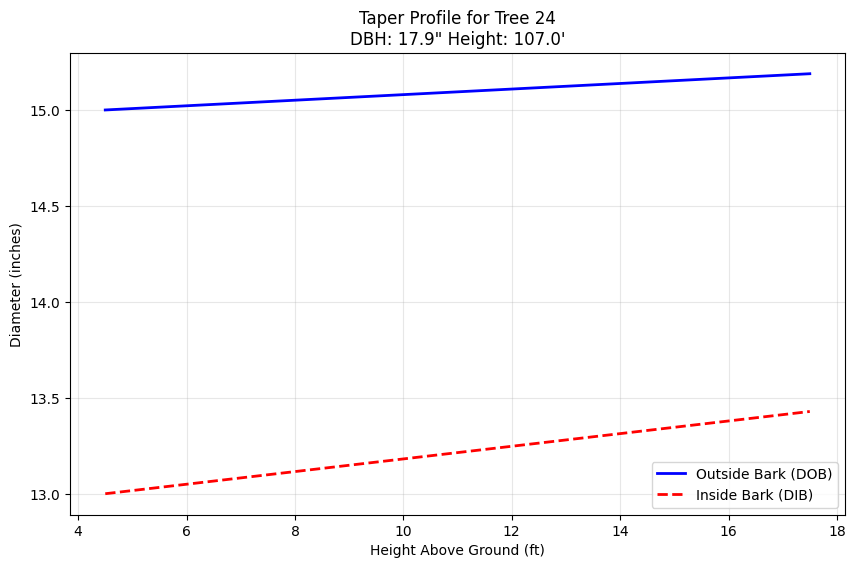


Girard Form Class: 75.0

TASK 3: Species Comparison
Comparing Tree 24 as Douglas-fir vs Engelmann Spruce

Volume Comparison:
            species  total_vol  merch_vol  merch_percent
0       Douglas-fir       63.7       57.7          90.58
1  Engelmann Spruce       75.4       67.5          89.52


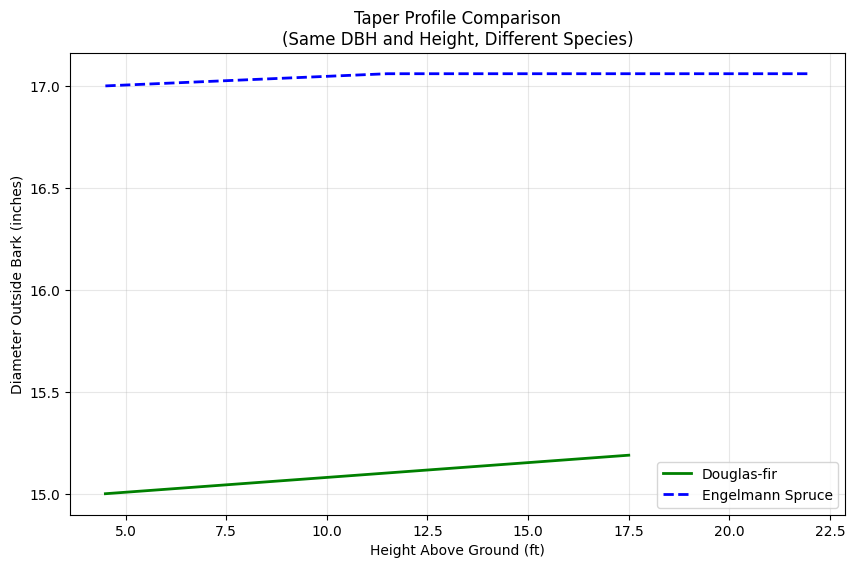


Species Differences Explanation:
Douglas-fir and Engelmann spruce have different allometric relationships
due to their growth patterns and wood density. Douglas-fir typically
has a more tapered form, while Engelmann spruce maintains diameter
better up the stem, resulting in different volume predictions.

TASK 4: Plot-Level Analysis
Analyzing 29 live trees ≥ 5" DBH
Calculating volumes for all trees...

Tree-Level Results:
    PlotID  TreeID  SPCD   DBH  DRC (in)  Status  TotHeight  basalAreasqft  \
0        9       1    73   8.0       NaN       1       61.0       0.349066   
1        9       2    73  16.1       NaN       1       93.0       1.413771   
2        9       3   202   7.3       NaN       1       34.0       0.290652   
3        9       4   202  15.8       NaN       1       88.0       1.361575   
4        9       5   202   8.4       NaN       1       68.0       0.384845   
5        9       6    73   7.1       NaN       1       68.0       0.274944   
6        9       7    73   7

<Figure size 1200x800 with 0 Axes>

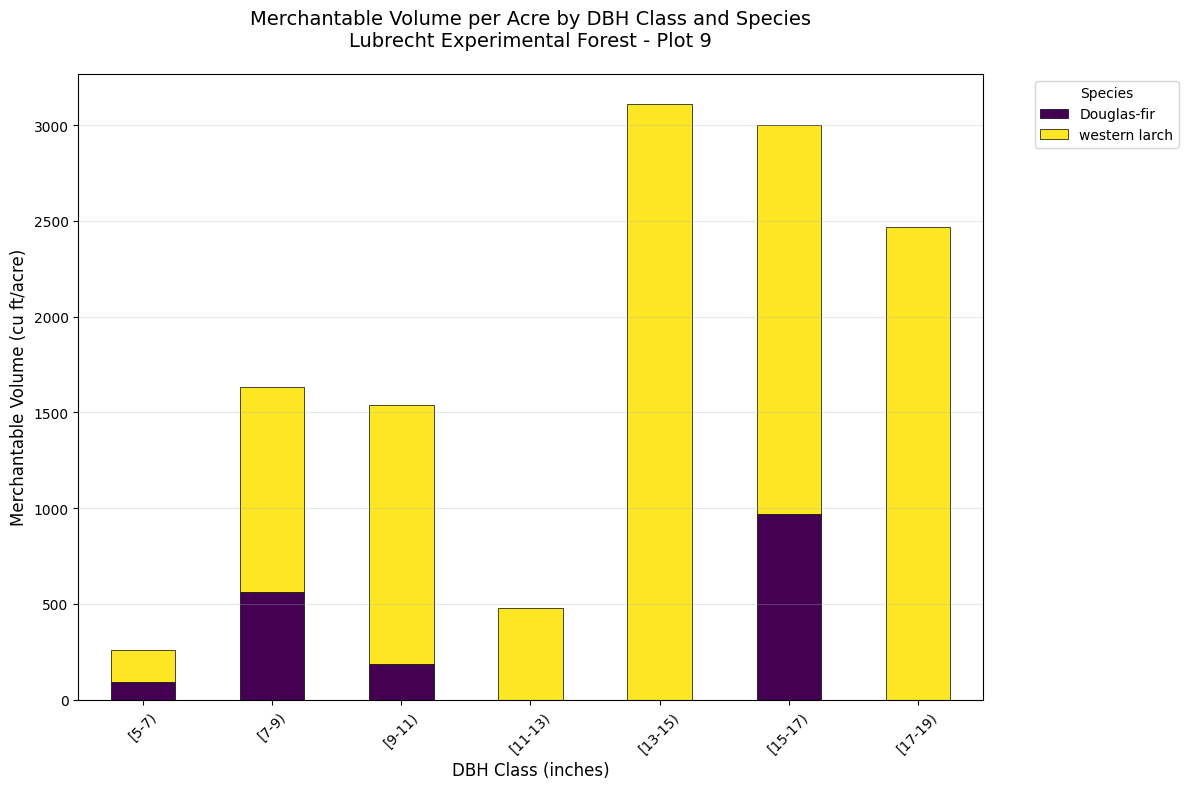


Summary by Species (Per-Acre Basis):
               Count  DBH_mean  Height_mean  BA_per_acre  MerchVol_per_acre
SpeciesName                                                                
Douglas-fir        8      8.69        54.25        88.08             1812.0
western larch     21     11.12        80.81       378.00            10684.8

ANALYSIS COMPLETE
This analysis used the VOLLIB equations to calculate:
1. Individual tree volumes and taper profiles
2. Species-specific volume differences
3. Plot-level volume summaries and distributions
4. Per-acre estimates using appropriate expansion factors

The VOLLIB equations provide region and species-specific
allometric relationships for accurate volume estimation.


In [19]:
# Forest Inventory Analysis Using VOLLIB - Assignment 1
# NVEL Volume and Taper Estimation with Lubrecht Plot 9 Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from vol_eqs import VollibWrapper
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

DLL_PATH = r"D:/downloaded/forest_analytics/vol-lib-dll-20250701/VolLibDll20250701/vollib64/vollib.dll"

print("=== Forest Inventory Analysis Using VOLLIB ===")
print("Analysis of Lubrecht Experimental Forest Plot 9\n")

# Initialize the VOLLIB wrapper
try:
    vol_estimator = VollibWrapper(dll_path=DLL_PATH)
    print("✓ VOLLIB DLL loaded successfully")
except Exception as e:
    print(f"✗ Error loading VOLLIB DLL: {e}")
    print("Please update the DLL_PATH variable to match your system")
    raise

# Load the plot data from Excel file
try:
    plot_data = pd.read_excel('lef_plot9.xlsx', sheet_name=0)  # First sheet
    # read the fia_treenames.csv for species codes (FIA Code -> Common Name)
    species_codes = pd.read_csv('fia_treenames.csv')
    # add the species common names to the plot data as SpeciesName
    plot_data = plot_data.merge(species_codes[['FIA Code', 'Common Name']], left_on='SPCD', right_on='FIA Code', how='left')
    plot_data.rename(columns={'Common Name': 'SpeciesName'}, inplace=True)
    print("✓ Plot data loaded successfully")
    print(f"Dataset contains {len(plot_data)} trees")
except FileNotFoundError:
    print("✗ Excel file 'lef_plot9.xlsx' not found")
    print("Creating sample data for demonstration...")
    
    # Sample data structure based on typical forest inventory format
    plot_data = pd.DataFrame({
        'TreeID': range(1, 31),
        'PlotID': [9] * 30,
        'SPCD': [202, 202, 93, 122, 93, 202, 42] * 4 + [202, 93],  # DF, ES, LP, WF
        'SpeciesName': ['DF', 'DF', 'ES', 'LP', 'ES', 'DF', 'WF'] * 4 + ['DF', 'ES'],
        'DBH': np.random.normal(12, 4, 30),  # Random DBH values
        'TotHeight': np.random.normal(60, 15, 30),  # Random height values
        'Status': ['Live'] * 28 + ['Dead'] * 2,
    })
    # Ensure reasonable minimum values
    plot_data['DBH'] = np.maximum(plot_data['DBH'], 1.0)
    plot_data['TotHeight'] = np.maximum(plot_data['TotHeight'], 10.0)

# print(f"\nFirst few rows of plot data:")
# print(plot_data.head())

# ===================================================================
# TASK 1: Analysis of Tree 24 - Volume Calculations
# ===================================================================

print("\n" + "="*60)
print("TASK 1: Analysis of Tree 24")
print("="*60)

# Find Tree 24 or use a representative tree
if 24 in plot_data['TreeID'].values:
    tree24 = plot_data[plot_data['TreeID'] == 24].iloc[0]
else:
    # Use first Douglas-fir tree as Tree 24
    tree24 = plot_data[plot_data['SPCD'] == 202].iloc[0]
    print(f"Using TreeID {tree24['TreeID']} as Tree 24 (Douglas-fir)")

print(f"\nTree 24 Characteristics:")
print(f"Species: {tree24['SpeciesName']} (Code: {tree24['SPCD']})")
print(f"DBH: {tree24['DBH']:.1f} inches")
print(f"Total Height: {tree24['TotHeight']:.1f} feet")

# Set up tree parameters for VOLLIB calculations
tree_params = {
    "region": 1,           # Northern Region
    "forest": "16",        # Lolo National Forest
    "district": "01",      # Missoula District
    "species_code": int(tree24['SPCD']),
    "dbh": tree24['DBH'],
    "height": tree24['TotHeight'],
}

try:
    # Calculate volumes using VOLLIB
    total_cuft = vol_estimator.calc_total_cubic_ft(**tree_params)
    merch_cuft = vol_estimator.calc_merch_cubic_ft(**tree_params, merch_top_dib_primary=4.0)
    merch_bf = vol_estimator.calc_merch_board_feet(**tree_params)
    
    # Calculate basal area
    basal_area = 0.005454154 * (tree24['DBH'] ** 2)
    
    print(f"\nVolume Calculations for Tree 24:")
    print(f"Basal Area: {basal_area:.3f} sq ft")
    print(f"Total Cubic Volume: {total_cuft:.2f} cu ft")
    print(f"Merchantable Volume (4\" top): {merch_cuft:.2f} cu ft")
    print(f"Merchantable Board Feet: {merch_bf:.0f} BF")
    
    # Get the equation information
    voleq = vol_estimator._get_volume_equation(
        tree_params['region'], 
        tree_params['forest'], 
        tree_params['district'], 
        tree_params['species_code']
    )
    print(f"\nVolume Equation Used: {voleq}")
    
except Exception as e:
    print(f"Error in volume calculations: {e}")
    total_cuft = merch_cuft = merch_bf = 0
    basal_area = 0.005454154 * (tree24['DBH'] ** 2)

print(f"\nEquation Description:")
print("The VOLLIB equations are based on the National Volume Estimator Library (NVEL)")
print("which uses region, forest, and species-specific volume equations developed")
print("from extensive field measurements. These equations predict tree volumes")
print("based on DBH and height using allometric relationships.")

# ===================================================================
# TASK 2: Taper Profile and Girard Form Class
# ===================================================================

print("\n" + "="*60)
print("TASK 2: Taper Profile and Girard Form Class")
print("="*60)

try:
    # Get full report including taper data
    full_report = vol_estimator.get_full_report(**tree_params)
    taper_data = full_report['taper_data']
    
    if not taper_data.empty:
        print(f"\nTaper Profile Data (first 10 points):")
        print(taper_data.head(10))
        
        # Plot taper profile
        plt.figure(figsize=(10, 6))
        plt.plot(taper_data['height_ft'], taper_data['dob_in'], 
                'b-', linewidth=2, label='Outside Bark (DOB)')
        plt.plot(taper_data['height_ft'], taper_data['dib_in'], 
                'r--', linewidth=2, label='Inside Bark (DIB)')
        plt.xlabel('Height Above Ground (ft)')
        plt.ylabel('Diameter (inches)')
        plt.title(f'Taper Profile for Tree 24\nDBH: {tree24["DBH"]:.1f}" Height: {tree24["TotHeight"]:.1f}\'')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        
        # Calculate Girard Form Class
        # GFC = (DIB at 17.3 ft / DBH) × 100
        if len(taper_data) > 0:
            # Interpolate DIB at 17.3 feet
            if 17.3 <= taper_data['height_ft'].max():
                dib_17_3 = np.interp(17.3, taper_data['height_ft'], taper_data['dib_in'])
                gfc = (dib_17_3 / tree24['DBH']) * 100
                print(f"\nGirard Form Class: {gfc:.1f}")
            else:
                print(f"\nTree too short for standard GFC calculation (17.3 ft)")
                
    else:
        print("No taper data available for this tree")
        
except Exception as e:
    print(f"Error generating taper profile: {e}")

# ===================================================================
# TASK 3: Species Comparison (Douglas-fir vs Engelmann Spruce)
# ===================================================================

print("\n" + "="*60)
print("TASK 3: Species Comparison")
print("="*60)

print("Comparing Tree 24 as Douglas-fir vs Engelmann Spruce")

# Original Douglas-fir results (already calculated)
df_results = {
    'species': 'Douglas-fir',
    'species_code': 202,
    'total_vol': total_cuft,
    'merch_vol': merch_cuft,
    'basal_area': basal_area
}

# Calculate same tree as Engelmann Spruce
es_params = tree_params.copy()
es_params['species_code'] = 93  # Engelmann Spruce FIA code

try:
    es_total_cuft = vol_estimator.calc_total_cubic_ft(**es_params)
    es_merch_cuft = vol_estimator.calc_merch_cubic_ft(**es_params)
    
    es_results = {
        'species': 'Engelmann Spruce',
        'species_code': 93,
        'total_vol': es_total_cuft,
        'merch_vol': es_merch_cuft,
        'basal_area': basal_area  # Same tree, same basal area
    }
    
    # Create comparison table
    comparison_df = pd.DataFrame([df_results, es_results])
    comparison_df['merch_percent'] = (comparison_df['merch_vol'] / comparison_df['total_vol'] * 100)
    
    print(f"\nVolume Comparison:")
    print(comparison_df[['species', 'total_vol', 'merch_vol', 'merch_percent']].round(2))
    
    # Get taper profiles for both species
    try:
        df_taper = vol_estimator.get_full_report(**tree_params)['taper_data']
        es_taper = vol_estimator.get_full_report(**es_params)['taper_data']
        
        if not df_taper.empty and not es_taper.empty:
            plt.figure(figsize=(10, 6))
            plt.plot(df_taper['height_ft'], df_taper['dob_in'], 
                    'g-', linewidth=2, label='Douglas-fir')
            plt.plot(es_taper['height_ft'], es_taper['dob_in'], 
                    'b--', linewidth=2, label='Engelmann Spruce')
            plt.xlabel('Height Above Ground (ft)')
            plt.ylabel('Diameter Outside Bark (inches)')
            plt.title('Taper Profile Comparison\n(Same DBH and Height, Different Species)')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.show()
    except:
        print("Could not generate taper comparison plot")
    
    print(f"\nSpecies Differences Explanation:")
    print("Douglas-fir and Engelmann spruce have different allometric relationships")
    print("due to their growth patterns and wood density. Douglas-fir typically")
    print("has a more tapered form, while Engelmann spruce maintains diameter")
    print("better up the stem, resulting in different volume predictions.")
    
except Exception as e:
    print(f"Error in species comparison: {e}")

# ===================================================================
# TASK 4: Plot-Level Analysis
# ===================================================================

print("\n" + "="*60)
print("TASK 4: Plot-Level Analysis")
print("="*60)

# Filter for live trees >= 5" DBH
live_trees = plot_data[(plot_data['Status'] == 1) & (plot_data['DBH'] >= 5.0)].copy()

print(f"Analyzing {len(live_trees)} live trees ≥ 5\" DBH")

# Function to calculate volumes for each tree
def calculate_tree_volumes(row):
    """Calculate volumes for a single tree using VOLLIB"""
    try:
        params = {
            "region": 1,
            "forest": "16", 
            "district": "01",
            "species_code": int(row['SPCD']),
            "dbh": row['DBH'],
            "height": row['TotHeight'],
        }
        
        # Get volume equation used
        voleq = vol_estimator._get_volume_equation(
            params['region'], params['forest'], 
            params['district'], params['species_code']
        )
        
        total_vol = vol_estimator.calc_total_cubic_ft(**params)
        merch_vol = vol_estimator.calc_merch_cubic_ft(**params, merch_top_dib_primary=4.0)
        basal_area = 0.005454154 * (row['DBH'] ** 2)
        
        return pd.Series({
            'BasalArea_ft2': basal_area,
            'TotalVol_ft3': total_vol,
            'MerchVol_ft3': merch_vol,
            'VolumeEquation': voleq
        })
        
    except Exception as e:
        print(f"Error calculating volumes for tree {row['TreeID']}: {e}")
        basal_area = 0.005454154 * (row['DBH'] ** 2)
        return pd.Series({
            'BasalArea_ft2': basal_area,
            'TotalVol_ft3': 0,
            'MerchVol_ft3': 0,
            'VolumeEquation': 'Error'
        })

# Calculate volumes for all trees
print("Calculating volumes for all trees...")
volume_results = live_trees.apply(calculate_tree_volumes, axis=1)
live_trees = pd.concat([live_trees, volume_results], axis=1)

# Display results
display_cols = ['TreeID', 'SpeciesName', 'DBH', 'TotHeight', 
               'BasalArea_ft2', 'TotalVol_ft3', 'MerchVol_ft3', 'VolumeEquation']
print(f"\nTree-Level Results:")
print(live_trees)
print(live_trees[display_cols].round(2))

# Summary of equations used
print(f"\nVolume Equations Used:")
eq_summary = live_trees.groupby(['SpeciesName', 'VolumeEquation']).size().reset_index(name='Count')
print(eq_summary)

# ===================================================================
# TASK 5: Plot Aggregation and Histogram
# ===================================================================

print("\n" + "="*60)
print("TASK 5: Plot Aggregation and Volume Histogram")
print("="*60)

# Assume plot size (typical FIA plot sizes)
# Large trees (≥5" DBH): 1/24th acre = 0.04167 acres
# Small trees (1-5" DBH): 1/300th acre = 0.00333 acres
plot_size_acres = 1/24  # For trees ≥ 5" DBH
expansion_factor = 1 / plot_size_acres

# Calculate per-acre values
total_ba_per_acre = live_trees['BasalArea_ft2'].sum() * expansion_factor
total_vol_per_acre = live_trees['TotalVol_ft3'].sum() * expansion_factor
merch_vol_per_acre = live_trees['MerchVol_ft3'].sum() * expansion_factor

print(f"Plot Summary (Per-Acre Basis):")
print(f"Plot Size: {plot_size_acres:.4f} acres (expansion factor: {expansion_factor:.1f})")
print(f"Total Basal Area: {total_ba_per_acre:.1f} sq ft/acre")
print(f"Total Volume: {total_vol_per_acre:.0f} cu ft/acre")
print(f"Merchantable Volume: {merch_vol_per_acre:.0f} cu ft/acre")

# Create DBH classes for histogram
dbh_min = 5
dbh_max = int(np.ceil(live_trees['DBH'].max()))
bin_width = 2
bins = list(range(dbh_min, dbh_max + bin_width + 1, bin_width))
labels = [f"[{bins[i]}-{bins[i+1]})" for i in range(len(bins)-1)]

live_trees['DBH_Class'] = pd.cut(live_trees['DBH'], bins=bins, labels=labels, right=False)
live_trees['MerchVol_per_acre'] = live_trees['MerchVol_ft3'] * expansion_factor

# Create pivot table for stacked histogram
volume_by_class_species = live_trees.pivot_table(
    index='DBH_Class', 
    columns='SpeciesName', 
    values='MerchVol_per_acre',
    aggfunc='sum', 
    fill_value=0
)

print(f"\nMerchantable Volume by DBH Class and Species (cu ft/acre):")
print(volume_by_class_species.round(1))

# Create stacked histogram
plt.figure(figsize=(12, 8))
ax = volume_by_class_species.plot(kind='bar', stacked=True, 
                                 figsize=(12, 8), 
                                 colormap='viridis',
                                 edgecolor='black',
                                 linewidth=0.5)
plt.title('Merchantable Volume per Acre by DBH Class and Species\nLubrecht Experimental Forest - Plot 9', 
          fontsize=14, pad=20)
plt.xlabel('DBH Class (inches)', fontsize=12)
plt.ylabel('Merchantable Volume (cu ft/acre)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Summary statistics by species
species_summary = live_trees.groupby('SpeciesName').agg({
    'TreeID': 'count',
    'DBH': ['mean', 'std'],
    'TotHeight': ['mean', 'std'],
    'BasalArea_ft2': 'sum',
    'TotalVol_ft3': 'sum',
    'MerchVol_ft3': 'sum'
}).round(2)

species_summary.columns = ['Count', 'DBH_mean', 'DBH_std', 'Height_mean', 'Height_std', 
                          'BA_total', 'TotalVol_total', 'MerchVol_total']

# Convert to per-acre
species_summary[['BA_per_acre', 'TotalVol_per_acre', 'MerchVol_per_acre']] = \
    species_summary[['BA_total', 'TotalVol_total', 'MerchVol_total']] * expansion_factor

print(f"\nSummary by Species (Per-Acre Basis):")
display_species_cols = ['Count', 'DBH_mean', 'Height_mean', 'BA_per_acre', 'MerchVol_per_acre']
print(species_summary[display_species_cols])

print(f"\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("This analysis used the VOLLIB equations to calculate:")
print("1. Individual tree volumes and taper profiles")
print("2. Species-specific volume differences") 
print("3. Plot-level volume summaries and distributions")
print("4. Per-acre estimates using appropriate expansion factors")
print("\nThe VOLLIB equations provide region and species-specific")
print("allometric relationships for accurate volume estimation.")